# Training Pipeline Test

Quick notebook to test loading data, forward pass, and loss calculation.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path

from humchess.data.pgn_dataset import PGNDataset, collate_fn
from humchess.model.transformer import ChessTransformer
from humchess.data.tokenization import SEQ_LENGTH, NUM_MOVE_CLASSES, NUM_PROMO_CLASSES

## 1. Load a Parquet Shard

In [2]:
# Use a single shard for testing
shard_path = Path('../data/tokenized/lichess_db_standard_rated_2017-04_games_10015865-10025878.parquet')
print(f'Loading: {shard_path}')
print(f'Exists: {shard_path.exists()}')

dataset = PGNDataset.from_parquet([shard_path])
print(f'Dataset created')

Loading: ../data/tokenized/lichess_db_standard_rated_2017-04_games_10015865-10025878.parquet
Exists: True
Dataset created


In [6]:
# Create dataloader
batch_size = 256
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=0,  # Use 0 for notebook debugging
    collate_fn=collate_fn,
)

# # Get a batch
# batch = next(iter(dataloader))
# print('Batch contents:')
# for k, v in batch.items():
#     if isinstance(v, torch.Tensor):
#         print(f'  {k}: shape={v.shape}, dtype={v.dtype}')
#     else:
#         print(f'  {k}: {type(v)}')

seen = 0
for i, batch in enumerate(dataloader):
    if i == 12:
        break

    seen += batch['tokens'].shape[0]

print(f'Total samples seen in 12 batches: {seen}')

Worker 0 reading Parquet file: ../data/tokenized/lichess_db_standard_rated_2017-04_games_10015865-10025878.parquet
Total samples seen in 12 batches: 3072


## 2. Inspect a Sample

In [4]:
# Look at first sample in batch
tokens = batch['tokens'][230]
move_id = batch['move_id'][230]
legal_mask = batch['legal_mask'][230]
promo_id = batch['promo_id'][230].item()

print(f'Tokens: {tokens.tolist()}')
print(f'\nToken breakdown:')
print(f'  CLS token: {tokens[0].item()}')
print(f'  Board squares (1-64): {tokens[1:65].tolist()}')
print(f'  Metadata (65-67): {tokens[65:].tolist()}')
print(f'\nTarget move_id: {move_id.item()}')
print(f'  From square: {move_id.item() // 64}')
print(f'  To square: {move_id.item() % 64}')
print(f'\nLegal moves: {legal_mask.sum().item()}')
print(f'promo_id: {promo_id}')

Tokens: [13, 4, 2, 3, 5, 6, 3, 2, 4, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 7, 7, 7, 0, 0, 7, 7, 7, 10, 8, 9, 11, 12, 9, 8, 10, 29, 41, 53]

Token breakdown:
  CLS token: 13
  Board squares (1-64): [4, 2, 3, 5, 6, 3, 2, 4, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 7, 7, 7, 0, 0, 7, 7, 7, 10, 8, 9, 11, 12, 9, 8, 10]
  Metadata (65-67): [29, 41, 53]

Target move_id: 2347
  From square: 36
  To square: 43

Legal moves: 29
promo_id: -1


## 2b. Visualize Board and Move

Render the tokenized board as a chess board with the target move highlighted.

Sample 0:
  Move: e5d6 (e5 → d6)
  Elo bucket: 2000-2100
  Time bucket: 240-300s
  FEN: rnbqkbnr/ppp2ppp/4p3/3pP3/8/8/PPPP1PPP/RNBQKBNR w KQkq - 0 1


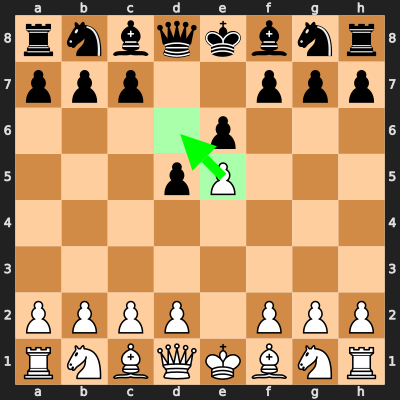

In [5]:
import chess
import chess.svg
from IPython.display import SVG, display

from humchess.data.tokenization import (
    Piece, idx_to_square_name, ids_to_move,
    parse_castling_token, ELO_BUCKET_BASE, ELO_BUCKET_BOUNDARIES,
    TL_BUCKET_BASE, TL_BUCKET_BOUNDARIES_SECONDS, TL_UNKNOWN_IDX,
)

def tokens_to_board(tokens: list[int]) -> chess.Board:
    """Convert token sequence back to a chess.Board (normalized = white to move)."""
    # Token to piece mapping (reverse of PIECE_TYPE_COLOR_TO_TOKEN)
    TOKEN_TO_PIECE = {
        Piece.WP: chess.Piece(chess.PAWN, chess.WHITE),
        Piece.WN: chess.Piece(chess.KNIGHT, chess.WHITE),
        Piece.WB: chess.Piece(chess.BISHOP, chess.WHITE),
        Piece.WR: chess.Piece(chess.ROOK, chess.WHITE),
        Piece.WQ: chess.Piece(chess.QUEEN, chess.WHITE),
        Piece.WK: chess.Piece(chess.KING, chess.WHITE),
        Piece.BP: chess.Piece(chess.PAWN, chess.BLACK),
        Piece.BN: chess.Piece(chess.KNIGHT, chess.BLACK),
        Piece.BB: chess.Piece(chess.BISHOP, chess.BLACK),
        Piece.BR: chess.Piece(chess.ROOK, chess.BLACK),
        Piece.BQ: chess.Piece(chess.QUEEN, chess.BLACK),
        Piece.BK: chess.Piece(chess.KING, chess.BLACK),
    }
    
    board = chess.Board.empty()
    board.turn = chess.WHITE  # Always white to move after normalization
    
    # Set pieces from tokens[1:65]
    for sq in range(64):
        piece_token = tokens[sq + 1]
        if piece_token != Piece.EMPTY:
            board.set_piece_at(sq, TOKEN_TO_PIECE[piece_token])
    
    # Set castling rights from tokens[65]
    wk, wq, bk, bq = parse_castling_token(tokens[65])
    castling_fen = ''
    if wk: castling_fen += 'K'
    if wq: castling_fen += 'Q'
    if bk: castling_fen += 'k'
    if bq: castling_fen += 'q'
    board.set_castling_fen(castling_fen or '-')
    
    return board

def decode_elo_bucket(token: int) -> str:
    """Decode Elo bucket token to human-readable string."""
    idx = token - ELO_BUCKET_BASE
    if idx == 0:
        return f"<{ELO_BUCKET_BOUNDARIES[0]}"
    elif idx >= len(ELO_BUCKET_BOUNDARIES):
        return f"≥{ELO_BUCKET_BOUNDARIES[-1]}"
    else:
        return f"{ELO_BUCKET_BOUNDARIES[idx-1]}-{ELO_BUCKET_BOUNDARIES[idx]}"

def decode_time_bucket(token: int) -> str:
    """Decode time-left bucket token to human-readable string."""
    idx = token - TL_BUCKET_BASE
    if idx == TL_UNKNOWN_IDX:
        return "unknown"
    elif idx == 0:
        return f"<{TL_BUCKET_BOUNDARIES_SECONDS[0]}s"
    elif idx >= len(TL_BUCKET_BOUNDARIES_SECONDS):
        return f"≥{TL_BUCKET_BOUNDARIES_SECONDS[-1]}s"
    else:
        return f"{TL_BUCKET_BOUNDARIES_SECONDS[idx-1]}-{TL_BUCKET_BOUNDARIES_SECONDS[idx]}s"

def visualize_position(tokens, move_id, promo_id=None, sample_idx=0):
    """Visualize a tokenized position with the target move highlighted."""
    tokens_list = tokens.tolist() if hasattr(tokens, 'tolist') else list(tokens)
    move_id_val = move_id.item() if hasattr(move_id, 'item') else int(move_id)
    
    # Decode move
    from_sq = move_id_val // 64
    to_sq = move_id_val % 64
    move_uci = ids_to_move(move_id_val, promo_id)
    
    # Reconstruct board
    board = tokens_to_board(tokens_list)
    
    # Decode metadata
    elo_str = decode_elo_bucket(tokens_list[66])
    time_str = decode_time_bucket(tokens_list[67])
    
    # Create SVG with highlighted squares
    arrows = [chess.svg.Arrow(from_sq, to_sq, color='#00ff00')]
    svg = chess.svg.board(
        board,
        arrows=arrows,
        fill={from_sq: '#aaffaa', to_sq: '#aaffaa'},
        size=400,
    )
    
    print(f"Sample {sample_idx}:")
    print(f"  Move: {move_uci} ({idx_to_square_name(from_sq)} → {idx_to_square_name(to_sq)})")
    print(f"  Elo bucket: {elo_str}")
    print(f"  Time bucket: {time_str}")
    print(f"  FEN: {board.fen()}")
    display(SVG(svg))

# # Visualize first sample
# tokens = batch['tokens'][0]
# move_id = batch['move_id'][0]
# promo_id = batch['promo_id'][0].item()
# promo_id = promo_id if promo_id >= 0 else None

visualize_position(tokens, move_id, promo_id if promo_id >= 0 else None, sample_idx=0)

In [ ]:
# Interactive sample browser with prev/next buttons
import ipywidgets as widgets
from IPython.display import clear_output

class SampleBrowser:
    def __init__(self, batch):
        self.batch = batch
        self.idx = 0
        self.max_idx = batch['tokens'].shape[0] - 1
        
        # Widgets
        self.prev_btn = widgets.Button(description='◀ Prev', layout=widgets.Layout(width='80px'))
        self.next_btn = widgets.Button(description='Next ▶', layout=widgets.Layout(width='80px'))
        self.slider = widgets.IntSlider(value=0, min=0, max=self.max_idx, description='Sample:')
        self.output = widgets.Output()
        
        # Event handlers
        self.prev_btn.on_click(self._prev)
        self.next_btn.on_click(self._next)
        self.slider.observe(self._on_slider, names='value')
        
        # Layout
        buttons = widgets.HBox([self.prev_btn, self.next_btn, self.slider])
        self.widget = widgets.VBox([buttons, self.output])
        
        self._render()
    
    def _prev(self, _):
        if self.idx > 0:
            self.idx -= 1
            self.slider.value = self.idx
    
    def _next(self, _):
        if self.idx < self.max_idx:
            self.idx += 1
            self.slider.value = self.idx
    
    def _on_slider(self, change):
        self.idx = change['new']
        self._render()
    
    def _render(self):
        with self.output:
            clear_output(wait=True)
            tokens = self.batch['tokens'][self.idx]
            move_id = self.batch['move_id'][self.idx]
            promo_id = self.batch['promo_id'][self.idx].item()
            promo_id = promo_id if promo_id >= 0 else None
            visualize_position(tokens, move_id, promo_id, sample_idx=self.idx)
    
    def display(self):
        display(self.widget)

# Create and display browser
browser = SampleBrowser(batch)
browser.display()

## 3. Create Model

In [ ]:
# Model config (matches configs/model.yml)
model_config = {
    'd_model': 256,
    'n_heads': 8,
    'n_layers': 6,
    'd_ff': 1024,
}

model = ChessTransformer(**model_config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f'Device: {device}')
print(f'Model parameters: {model.count_parameters():,}')
print(f'\nModel architecture:')
print(model)

## 4. Forward Pass

In [ ]:
# Move batch to device
tokens = batch['tokens'].to(device)
move_targets = batch['move_id'].to(device)
promo_targets = batch['promo_id'].to(device)
legal_mask = batch['legal_mask'].to(device)
is_promotion = batch['is_promotion'].to(device)

# Forward pass
model.eval()
with torch.no_grad():
    outputs = model(tokens)

move_logits = outputs['move_logits']
promo_logits = outputs['promo_logits']

print(f'Move logits: shape={move_logits.shape}')
print(f'Promo logits: shape={promo_logits.shape}')

## 5. Loss Calculation

In [ ]:
def masked_cross_entropy(logits, targets, mask):
    """Cross-entropy with legality masking."""
    masked_logits = logits.clone()
    masked_logits[~mask] = float('-inf')
    return nn.functional.cross_entropy(masked_logits, targets)

# Move loss (always computed)
move_loss = masked_cross_entropy(move_logits, move_targets, legal_mask)
print(f'Move loss: {move_loss.item():.4f}')

# Promotion loss (only for promotions)
if is_promotion.any():
    promo_loss = nn.functional.cross_entropy(
        promo_logits[is_promotion],
        promo_targets[is_promotion],
    )
    print(f'Promo loss: {promo_loss.item():.4f}')
    print(f'Promotions in batch: {is_promotion.sum().item()}')
else:
    promo_loss = torch.tensor(0.0)
    print('No promotions in this batch')

total_loss = move_loss + promo_loss
print(f'\nTotal loss: {total_loss.item():.4f}')

## 6. Accuracy Calculation

In [ ]:
with torch.no_grad():
    # Apply mask before argmax
    masked_logits = move_logits.clone()
    masked_logits[~legal_mask] = float('-inf')
    preds = masked_logits.argmax(dim=-1)
    
    correct = (preds == move_targets).sum().item()
    total = len(move_targets)
    
    print(f'Move accuracy: {correct}/{total} = {correct/total*100:.1f}%')
    print(f'(Random baseline with ~30 legal moves: ~3.3%)')

## 7. Training Step

In [ ]:
# Full training step
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Get fresh batch
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, collate_fn=collate_fn)
batch = next(iter(dataloader))

tokens = batch['tokens'].to(device)
move_targets = batch['move_id'].to(device)
promo_targets = batch['promo_id'].to(device)
legal_mask = batch['legal_mask'].to(device)
is_promotion = batch['is_promotion'].to(device)

# Forward
outputs = model(tokens)
move_logits = outputs['move_logits']
promo_logits = outputs['promo_logits']

# Loss
move_loss = masked_cross_entropy(move_logits, move_targets, legal_mask)
promo_loss = torch.tensor(0.0, device=device)
if is_promotion.any():
    promo_loss = nn.functional.cross_entropy(
        promo_logits[is_promotion],
        promo_targets[is_promotion],
    )
loss = move_loss + promo_loss

# Backward
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f'Training step completed')
print(f'Loss: {loss.item():.4f}')

## 8. Test with Mixed Precision

In [ ]:
if device.type == 'cuda':
    # Test bf16 training
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, collate_fn=collate_fn)
    batch = next(iter(dataloader))
    
    tokens = batch['tokens'].to(device)
    move_targets = batch['move_id'].to(device)
    legal_mask = batch['legal_mask'].to(device)
    
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        outputs = model(tokens)
        move_logits = outputs['move_logits']
        loss = masked_cross_entropy(move_logits, move_targets, legal_mask)
    
    print(f'bf16 forward pass successful')
    print(f'Loss: {loss.item():.4f}')
    print(f'Move logits dtype: {move_logits.dtype}')
else:
    print('Skipping mixed precision test (no CUDA)')

## 9. Throughput Test

In [ ]:
import time

# Warmup
for _ in range(5):
    outputs = model(tokens)
    loss = masked_cross_entropy(outputs['move_logits'], move_targets, legal_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

if device.type == 'cuda':
    torch.cuda.synchronize()

# Measure
n_steps = 50
start = time.perf_counter()

for _ in range(n_steps):
    outputs = model(tokens)
    loss = masked_cross_entropy(outputs['move_logits'], move_targets, legal_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

if device.type == 'cuda':
    torch.cuda.synchronize()

elapsed = time.perf_counter() - start
samples_per_sec = (n_steps * batch_size) / elapsed
steps_per_sec = n_steps / elapsed

print(f'Throughput test ({n_steps} steps, batch_size={batch_size}):')
print(f'  {steps_per_sec:.1f} steps/sec')
print(f'  {samples_per_sec:.0f} samples/sec')